# Import

In [ ]:
!pip install pyclustering -q
!pip install qiskit -q 
!pip install qutip -q
!pip install pylatexenc -q

In [ ]:
import numpy as np
import math
import cmath
from numpy import linalg as LA
from numpy import pi as pi
from random import *
from qutip import *
import matplotlib.pyplot as plt
from pyclustering.cluster import cluster_visualizer;
from pyclustering.cluster.kmedoids import kmedoids;
from sklearn import metrics
from scipy.stats import unitary_group
from numpy import unravel_index

# Clustering Experiments

## Experiment 1: Cluster Computational/Fourier/GBS Bases

### Generate Basis

In [ ]:
def generateComputationalBasis(dimension):
    """
    dimension: the dimension N specifies the basis to be |o>, |1>, ..., |N>
    return:
        each row is a computational basis
    """
    return np.identity(dimension)

In [ ]:
generateComputationalBasis(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:
def generateFourierBasis(dimension):
    """
    dimension: the dimension N specifies the basis transformed on |o>, |1>, ..., |N>
    return:
        each row is a Fourier basis
    """
    fourierBasis = []
    for k in range(dimension):
        kthBasis = []
        for j in range(dimension):
            kthBasis.append(1/np.sqrt(dimension) * np.exp(2*pi*1j*j*k/dimension))
        fourierBasis.append(kthBasis)
    return np.array(fourierBasis)

In [ ]:
generateFourierBasis(4)

array([[ 5.00000000e-01+0.0000000e+00j,  5.00000000e-01+0.0000000e+00j,
         5.00000000e-01+0.0000000e+00j,  5.00000000e-01+0.0000000e+00j],
       [ 5.00000000e-01+0.0000000e+00j,  3.06161700e-17+5.0000000e-01j,
        -5.00000000e-01+6.1232340e-17j, -9.18485099e-17-5.0000000e-01j],
       [ 5.00000000e-01+0.0000000e+00j, -5.00000000e-01+6.1232340e-17j,
         5.00000000e-01-1.2246468e-16j, -5.00000000e-01+1.8369702e-16j],
       [ 5.00000000e-01+0.0000000e+00j, -9.18485099e-17-5.0000000e-01j,
        -5.00000000e-01+1.8369702e-16j,  2.75545530e-16+5.0000000e-01j]])

In [ ]:
def generateVector(dimension, k=None):
    '''
    dimension: the dimension of the vector
    k: the kth element to be 1
    reutrn:
        a complex vector where the kth element is 1 and the rest is 0
        array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])
    '''
    vec = np.zeros(shape=dimension)
    if k != None:
        vec[k] = 1
    return vec.astype(complex)

def generateGBSBasis(dimension):
    """
    For a quantum system with D distinguishable states, two such systems form a
    bipartite system where such GBS basis is defined. Each basis would be a
    distinguishable state for the bipartite system, so no Bloch plot is available 

    dimension: d = D x D bipartite quantum systems
    return:
        D x D bell states as basis
    """
    D = int(np.sqrt(dimension))
    bellBasis = []
    for m in range(D):
        for n in range(D):
            mnBasis = generateVector(dimension)
            for k in range(D):
                mnBasis += 1/np.sqrt(D) * np.exp(2*pi*1j*m*k/D) * np.kron(generateVector(D, k), generateVector(D, (k-n)%D))
            bellBasis.append(mnBasis)
    return np.array(bellBasis)

In [ ]:
generateGBSBasis(4)

array([[ 0.70710678+0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j,  0.70710678+0.00000000e+00j],
       [ 0.        +0.00000000e+00j,  0.70710678+0.00000000e+00j,
         0.70710678+0.00000000e+00j,  0.        +0.00000000e+00j],
       [ 0.70710678+0.00000000e+00j,  0.        +0.00000000e+00j,
         0.        +0.00000000e+00j, -0.70710678+8.65956056e-17j],
       [ 0.        +0.00000000e+00j,  0.70710678+0.00000000e+00j,
        -0.70710678+8.65956056e-17j,  0.        +0.00000000e+00j]])

### Calculate Incompatibility -- Noise Free

In [ ]:
def getSumOfPQPQ(base1, base2):
    '''
    return: sum_i sum_j Tr [P_i@Q_j@P_i@Q_j]
    '''
    CBM = base2 @ np.matrix.getH(base1)
    return LA.norm(np.multiply(np.conjugate(CBM), CBM)) ** 2

def mutualDisturbance(base1, base2):
    '''
    return: 1 - 1/d * sum_i sum_j Tr [P_i@Q_j@P_i@Q_j]
    '''
    dimension = base1.shape[0]
    sumOfPQPQ = getSumOfPQPQ(base1, base2)
    incompatibility = 1 - (1/(dimension))* sumOfPQPQ
    return incompatibility

def constructAidMatrix(measurements):
    '''
    construct half of the matrix of distance in advance for an efficient
    construction of the whole distance matrix

    measurements: a list of measurements where each measurement is
        described by a matrix, where each row of the matrix is a basis
    return: Triangular distance matrix
    '''
    length = len(measurements)
    memory = np.zeros((length, length))
    for i in range(length):
        for j in range(i, length):
            memory[i, j] = mutualDisturbance(measurements[i], measurements[j])
            memory[j, i] = memory[i, j]
    return memory

def distanceMatrix(bases, listOfMeasurements):
    '''
    create the distance matrix

    bases: a list of indices indicating the measurement
        [0,1,2,2,2,1,1,0,0,1,...]
    listOfMeasurements: a list of possible kinds of measurements
        [computational, fourier, GBS]

    return: The distance matrix between each pair of bases
    '''
    length = len(bases)
    distanceMatrix = np.zeros((length, length))

    # Constructed to simplify the computation and to increase efficiency
    memorize = constructAidMatrix(listOfMeasurements)
    for i in range(0, length):
        for j in range(i, length):
            if i == j:
                distanceMatrix[i, i] = 0
            else:
                basei = bases[i]
                basej = bases[j]
                distanceMatrix[i, j] = memorize[basei, basej]
                distanceMatrix[j, i] = distanceMatrix[i, j]
    return distanceMatrix

In [ ]:
print(mutualDisturbance(generateComputationalBasis(2), generateFourierBasis(2)))

0.5000000000000002


### Perform Clustering

In [ ]:
def initialSeed(bases, k, dist):
    '''
    pick out k points as the initial centers
    '''
    initialCenters = []
    numberOfBases = len(bases)
    for i in range(0, k):
        if i == 0:
            initialCenters.append(np.random.randint(numberOfBases))
        else:
            dist2centers = dist[:, initialCenters]
            min = np.amin(dist2centers, axis = 1)
            squareMin = min ** 2
            distribution = squareMin /np.sum(squareMin)
            nextSeed = np.random.choice(numberOfBases, 1, p = distribution)
            initialCenters.append(nextSeed.item())
    return initialCenters

# input number of bases & dimension
print("Please input the number of bases to be created, bases will be chosen uniformly at random from computational basis (0), fourier basis (1) and generalized bell states (2): ")
number = input()
number = int(float(number))

print("Please choose dimension of the system, this can only be an even power of 2: ")
dimension = input()
dimension = int(float(dimension))

# The possible measurements
measurements = [generateComputationalBasis(dimension), generateFourierBasis(dimension), generateGBSBasis(dimension)]

# Generate unformly at random a list of bases

counter = 0
# Repeat the experiment for 50 times
for i in range(50):

    # Bases list
    randBases = []
    for i in range(0, number):
        randBases.append(randint(0, 2))

    dist = distanceMatrix(randBases, measurements)

    # K-Medoids algorithm for processing distance matrix
    initial_medoids = initialSeed(randBases, 3, dist)
    kmedoids_instance = kmedoids(dist, initial_medoids, data_type='distance_matrix', ccore = True)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # Evaluation
    randBases = np.array(randBases)
    index1 = np.array(clusters[0])
    index2 = np.array(clusters[1])
    index3 = np.array(clusters[2])
    clusterResult = np.zeros(number, dtype = int)
    clusterResult[index1] = int(randBases[medoids[0]])
    clusterResult[index2] = int(randBases[medoids[1]])
    clusterResult[index3] = int(randBases[medoids[2]])
    if metrics.adjusted_rand_score(randBases, clusterResult) == 1:
        counter += 1

print("Out of 50, " + str(counter) + " experiments have achieved accurate clustering")

Please input the number of bases to be created, bases will be chosen uniformly at random from computational basis (0), fourier basis (1) and generalized bell states (2): 
100
Please choose dimension of the system, this can only be an even power of 2: 
4
Out of 50, 50 experiments have achieved accurate clustering


## Experiment 2: Cluster Noisy Measurements

### Calculate Incompatibility -- Noisy Definition

In [ ]:
def getSquareRoot(A):
    return Qobj(A).sqrtm().full()

In [ ]:
def mutualDisturbance(base1, base2):
    '''
    calculate the incompatibility

    return: refer to the noisy definition of incompatibility in the paper 
    '''
    
    # get the POVMs of the two measurements
    povms1 = []
    povms2 = []
    for row in base1:
        new_row = row.reshape(-1, 1)
        povms1.append(np.dot(new_row, np.matrix.getH(new_row)))
    for row in base2:
        new_row = row.reshape(-1, 1)
        povms2.append(np.dot(new_row, np.matrix.getH(new_row)))
    
    # get the measurement operator, i.e. the square root of the POVMs
    Es = []
    for P in povms1:
        E = getSquareRoot(P)
        Es.append(np.matrix.getH(E))
    Fs = []
    for Q in povms2:
        F = getSquareRoot(Q)
        Fs.append(np.matrix.getH(F))

    # calculate the incompatibility
    sum = 0

    for E in Es:
        for F in Fs:
            E_dagger = np.matrix.getH(E)
            P = E_dagger @ E
            F_dagger = np.matrix.getH(F)
            sum += np.trace(P @ F @ P @ F)

    denominator = 0
    for E in Es:
        E_dagger = np.matrix.getH(E)
        denominator += np.trace(E @ E_dagger @ E_dagger @ E)

    sum = 1 - sum / denominator
    sum = sum.real
    sum = sum * 2
    if np.isclose(sum, 0) or abs(sum) < 1e-5:
        sum = 0
    sum = np.sqrt(sum)

    return sum


In [ ]:
def distanceMatrix(bases):
    length = len(bases)
    dist = np.zeros((length, length))
    for i in range(0, length):
        for j in range(i, length):
            if i == j:
                dist[i, i] = 0
            else:
                basei = bases[i]
                basej = bases[j]
                dist[i, j] = mutualDisturbance(basei, basej)
                dist[j, i] = dist[i, j]
    return dist

### Generate The Perturbed Bases

In [ ]:
def perturbatedBases(numberOfBases):
    
    bases = []
    labels = []
    blochVec = []
    for i in range(numberOfBases):
        j = i%2
        xp = []
        yp = []
        zp = []
        if (j == 0):
            # perturbated computational basis
            # add pertubation in range [0, pi/8]
            perTheta =  np.random.uniform(size = 1, low = 0, high = 1.0/16.0 * math.pi )
            # make the pertubation circulate
            perPsi = np.random.uniform(size = 1, low = 0, high = 2 * math.pi )
            theta0 = perTheta
            psi0 = perPsi
            psi1 = psi0 + math.pi
            theta1 = math.pi - theta0
            per0 = np.array([cmath.cos(theta0/2), cmath.sin(theta0/2)*cmath.exp(1j*psi0)])
            per1 = np.array([cmath.cos(theta1/2), cmath.sin(theta1/2)*cmath.exp(1j*psi1)])
            bases.append(np.vstack((per0, per1)))
            labels.append(0)
            blochVec.append([math.sin(theta0)*math.cos(psi0), math.sin(theta0)*math.sin(psi0), math.cos(theta0)])
            blochVec.append([math.sin(theta1)*math.cos(psi1), math.sin(theta1)*math.sin(psi1), math.cos(theta1)])
        elif(j == 1):
            # perturbated computational basis
            # add pertubation in range [0, pi/8]
            perTheta =  np.random.uniform(size = 1, low = -1.0/16.0 * math.pi, high = 1.0/16.0 * math.pi )
            perPsi =  np.random.uniform(size = 1, low = -1.0/16.0 * math.pi, high = 1.0/16.0 * math.pi )
            thetaPlus = math.pi/2 + perTheta
            psiPlus = perPsi
            thetaMinus = math.pi - thetaPlus
            psiMinus = psiPlus + math.pi
            perPlus = np.array([cmath.cos(thetaPlus/2), cmath.sin(thetaPlus/2)*cmath.exp(1j*psiPlus)])
            perMinus = np.array([cmath.cos(thetaMinus/2), cmath.sin(thetaMinus/2)*cmath.exp(1j*psiMinus)])
            bases.append(np.vstack((perPlus, perMinus)))

            labels.append(1)
            blochVec.append([math.sin(thetaPlus)*math.cos(psiPlus), math.sin(thetaPlus)*math.sin(psiPlus), math.cos(thetaPlus)])
            blochVec.append([math.sin(thetaMinus)*math.cos(psiMinus), math.sin(thetaMinus)*math.sin(psiMinus), math.cos(thetaMinus)])

    return bases, labels, blochVec

### Perform Clustering

Input the number of bases to create: 
100


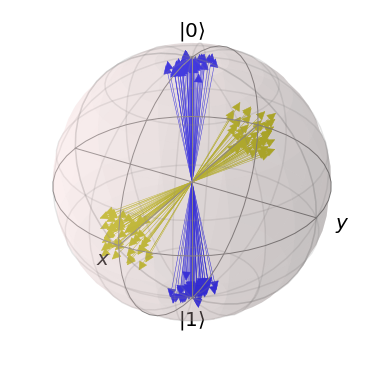

The average score is: 1.0


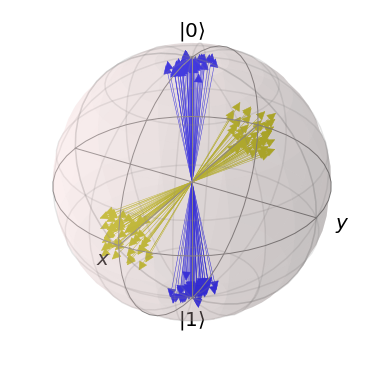

In [ ]:
def initialSeed(bases, k, dist):
    initialCenters = []
    numberOfBases = len(bases)
    for i in range(0, k):
        if i == 0:
            initialCenters.append(np.random.randint(numberOfBases))
        else:
            dist2centers = dist[:, initialCenters]
            min = np.amin(dist2centers, axis = 1)
            squareMin = min ** 2
            distribution = squareMin /np.sum(squareMin)
            nextSeed = np.random.choice(numberOfBases, 1, p = distribution)
            initialCenters.append(nextSeed.item())
    return initialCenters


print("Input the number of bases to create: ")
number = input()
number = int(float(number))

# drawing
randBases, labels, blochVec = perturbatedBases(number)
blochSphere = Bloch()
blochSphere.add_vectors(blochVec)
blochSphere.vector_color = ['blue', 'blue', 'y', 'y']
blochSphere.vector_width = 0.5
blochSphere.show()


# testing
totalScore = 0
for i in range(50):
    randBases, labels, blochVec= perturbatedBases(number)
    dist = distanceMatrix(randBases)
    initial_medoids = initialSeed(randBases, 2, dist)

    # create K-Medoids algorithm for processing distance matrix instead of points
    kmedoids_instance = kmedoids(dist, initial_medoids, data_type='distance_matrix', ccore = True)
    # run cluster analysis and obtain results
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    labels = np.array(labels)
    index1 = np.array(clusters[0])
    index2 = np.array(clusters[1])

    cluster1 = labels[index1]
    cluster2 = labels[index2]

    #this is for comparison of clustering result and ground truth
    clusterResult = np.zeros(number, dtype = int)
    clusterResult[index1] = int(labels[medoids[0]])
    clusterResult[index2] = int(labels[medoids[1]])
    totalScore +=metrics.adjusted_mutual_info_score(labels, clusterResult)

print("The average score is: " + str(totalScore * 1.0/50))